In [1]:
import os
import json
import pandas as pd
import numpy as np
import ConfigReader
import preprocess
import random

import numpy as np
from PIL import Image

import cv2
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('50sensor_power_2tx_latlon_5g.csv')
df.head()

,time,tx,id,power,lon,lat,dbm
0,0.00,500,16,4.996616e-13,3.06045,50.63294,-123.0
1,0.02,500,16,5.004682e-13,3.06045,50.63294,-123.0
2,0.04,500,16,5.013803e-13,3.06045,50.63294,-123.0
3,0.06,500,16,5.021966e-13,3.06045,50.63294,-123.0
4,0.08,500,16,5.031786e-13,3.06045,50.63294,-123.0


## load config

In [3]:
config = ConfigReader.GetModelConfig("./Temp/my_config.json")
config

{'grid_size': 100,
 'generator_lr': 0.001,
 'discriminator_lr': 0.001,
 'pre_train_epoch': 1,
 'train_epoch': 1,
 'batch_size': 20,
 'mean_shift_radius': 25,
 'mean_shift_bandwith': 20,
 'strange_num': 0,
 'low_data_path': 'Temp/low_data.npy',
 'high_data_path': 'Temp/high_data.npy',
 'model_out_path': 'Temp/SI-AGAN.pth',
 'log_path': 'Temp/SI-AGAN-log.txt'}

In [4]:
GENERATOR_LR = config["generator_lr"]  # 0.001
DISCRIMINATOR_LR = config["discriminator_lr"]  # 0.001
PRE_TRAIN_EPOCH = config["pre_train_epoch"]  # 2
TRAIN_EPOCH = config["train_epoch"]  # 10
BATCH_SIZE = config["batch_size"]  # 5
MODEL_OUT_PATH = config["model_out_path"]  # "../Temp/Generator.pth"
UP_SAMPLE = 1
IS_CUDA = False
log_path = config["log_path"]
low_data_path = config['low_data_path']
high_data_path = config['high_data_path']
model_out_path = config['model_out_path']

## split train and test data

In [5]:
time_set = set(df['time'])
len(time_set)

3001

In [6]:
random.seed(5)
train_time_sep = random.sample(time_set,k=int(len(time_set)*0.9))
print(len(train_time_sep))
train_time_sep[: 10]

2700


C:\Users\fangfang.shang\AppData\Local\Temp\ipykernel_16872\1118068011.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_time_sep = random.sample(time_set,k=int(len(time_set)*0.9))


[4.48, 57.04, 2.76, 3.6, 0.48, 57.46, 43.5, 32.08, 44.04, 11.92]

In [7]:
test_time_sep = list(time_set - set(train_time_sep))
print(len(test_time_sep))
test_time_sep[: 10]

301


[0.54, 1.36, 2.18, 3.36, 4.08, 5.16, 6.0, 7.5, 7.8, 9.58]

In [8]:
df_train = df[df['time'].isin(train_time_sep)].sort_values('time').reset_index(drop=True)
df_train.head()

,time,tx,id,power,lon,lat,dbm
0,0.0,500,16,4.996616e-13,3.06045,50.63294,-123.0
1,0.0,501,29,7.476345e-12,3.06707,50.63558,-111.0
2,0.0,500,17,1.664575e-10,3.06141,50.63328,-98.0
3,0.0,500,42,2.192284e-10,3.05733,50.63295,-97.0
4,0.0,500,22,6.884540e-12,3.06588,50.63311,-112.0


In [9]:
df_test = df[df['time'].isin(test_time_sep)].sort_values('time').reset_index(drop=True)
df_test.head()

,time,tx,id,power,lon,lat,dbm
0,0.12,500,16,5.049263e-13,3.06045,50.63294,-123.0
1,0.12,501,39,2.337234e-11,3.06840,50.63656,-106.0
2,0.12,501,20,5.743208e-10,3.06742,50.63554,-92.0
3,0.12,501,2,9.852776e-11,3.06521,50.63314,-100.0
4,0.12,500,41,6.898391e-12,3.06091,50.63531,-112.0


## generate low data and high data

In [10]:
X = df_train[['time', 'lon', 'lat', 'dbm']]
X.head()

,time,lon,lat,dbm
0,0.0,3.06045,50.63294,-123.0
1,0.0,3.06707,50.63558,-111.0
2,0.0,3.06141,50.63328,-98.0
3,0.0,3.05733,50.63295,-97.0
4,0.0,3.06588,50.63311,-112.0


In [11]:
min_lon=df['lon'].min()
max_lon=df['lon'].max()
min_lat=df['lat'].min()
max_lat=df['lat'].max()
print(min_lon, max_lon, min_lat, max_lat)

3.05733 3.06976 50.63187 50.63699


## generate low data

In [12]:
# if low_data.npy and high_data.npy not exists, run this code
X = X.to_numpy()
preprocess.GenerateLowHighPair2(X, min_lon, max_lon, min_lat, max_lat, use_interpolation_scipy=False,generate_X=None,use_interpolation_lgb=False)

In [17]:
low_data = np.load(low_data_path)
low_data.shape

(2700, 100, 100)

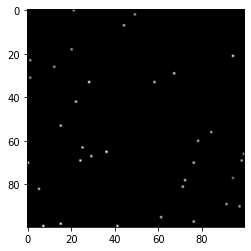

In [18]:
# save pictures
for i in range(low_data.shape[0]):
    a = low_data[i]
    plt.imshow(np.array(Image.fromarray(a)) , cmap=plt.cm.binary)
    plt.savefig(f'./low_data_pic/{i}.png')

## generate high data

In [14]:
# X = X.to_numpy()
preprocess.GenerateLowHighPair2(X, min_lon, max_lon, min_lat, max_lat, use_interpolation_scipy=True,generate_X=None,use_interpolation_lgb=False)

In [ ]:
high_data = np.load(high_data_path)
high_data.shape